# Generalized Linear Model
Bs Vương Kiến Thanh

## Phần 1: GLM Binomial Regression
(Hay còn gọi là logistic regression)  

Giới thiệu sơ lược về Generalized Linear Model:  
Một mô hình GLM cũng giống như linear regression đơn giản, và thêm 2 thành phần:
- Likelihood thuộc nhóm exponential: Binomial, Exponential, Gamma, Poisson,..
- Với mỗi likelihood đó có một link function riêng. 

Bài này giới thiệu Binom regression với **likelihood là binomial** và **link function là logit**.

---
## Nghiên cứu tính cộng đồng của loài khỉ chimpanzee
Trên một bàn dài, ở một đầu bàn, có 2 cây cần kéo với 2 thanh đẩy, thanh đẩy có thể có 1 đĩa chứa thức ăn hoặc 2 đĩa chứa thức ăn *(prosocial option)* .  
Khi kéo cần, thì đĩa thức ăn cùng bên sẽ về đầu bàn đó, đĩa thứ 2 trên cùng thanh đẩy nếu có sẽ về đầu bàn còn lại.  
Một con khỉ chimpanzee *(actor)* ngồi đầu bàn đó, đầu bàn còn lại có hoặc không có bạn khỉ *(partner)* .  
Kết cục sẽ là actor kéo cần bên *prosocial* hay bên còn lại.  
Thiết kế nghiên cứu sẽ ngẫu nhiên *prosocial* bên trái hoặc bên phải để tránh sai lệch do thuận tay của *actor*.

<img src="../docs/assets/images/fig 11-chimpanzee.svg">

In [1]:
import pandas as pd
import arviz as az
import numpy as np
import matplotlib.pyplot as plt

import numpyro
from numpyro import handlers, sample
import numpyro.distributions as dist
from numpyro.diagnostics import print_summary
from numpyro.infer import MCMC, NUTS, Predictive

import jax.numpy as jnp
from jax.scipy.special import expit, logit
from jax import vmap, random

az.style.use("fivethirtyeight")
#az.style.available

In [2]:
data_url = r"https://raw.githubusercontent.com/fehiepsi/rethinking-numpyro/master/data/chimpanzees.csv"

In [3]:
d = pd.read_csv(data_url, header=0, delimiter=";")
d.head()

,actor,recipient,condition,block,trial,prosoc_left,chose_prosoc,pulled_left
0,1,NaN,0,1,2,0,1,0
1,1,NaN,0,1,4,0,0,1
2,1,NaN,0,1,6,1,0,0
3,1,NaN,0,1,8,0,1,0
4,1,NaN,0,1,10,1,1,1


Ta sẽ thu gọn biến `prosoc_left` và `condition` thành `treatment` bằng phép tính đơn giản. Như vậy với giá trị của `treatment`:
- 0: `prosoc_left=0` và `condition=0` : 2 món thức ăn bên phải và không có partner.
- 1: `prosoc_left=1` và `condition=0` : 2 món thức ăn bên trái và không có partner.
- 2: `prosoc_left=0` và `condition=1` : 2 món thức ăn bên phải và có partner.
- 3: `prosoc_left=1` và `condition=1` : 2 món thức ăn bên trái và có partner.

In [4]:
d['treatment'] = d['prosoc_left'] + d['condition']*2
d = d.loc[:, ["actor", "treatment", "pulled_left"]]
d.head()

,actor,treatment,pulled_left
0,1,0,0
1,1,0,1
2,1,1,0
3,1,0,0
4,1,1,1


---
Mô hình GLM binomial regression:
$$\begin{matrix}
L_i &\sim& \text{Binomial}(1, p_i)\\
\text{logit}(p_i) &=& \alpha_{\text{actor}[i]} + \beta_{\text{treatment}[i]}\\ 
\alpha_j &\sim& \text{to be determined}\\
\beta_k &\sim& \text{to be determined}\\
\end{matrix}$$

Đây là mô hình GLM vì:
- likehood thuộc nhóm exponetial
- link function là logit

Logit hay còn gọi là log-odds:   
$$ \text{logit}(p) = \log \frac{p}{1-p}$$

Để tính ra $p$, ta dùng inv-logit:  
$$ p = \frac{\exp(\text{logit})}{1 + \exp(\text{logit})} $$

---

## Chọn prior:
Prior của $\alpha$ và $\beta$ chưa được chọn. Ta hãy xem xét với $\alpha$ trước.  
Ta sẽ dựng mô hình đơn giản với một biến $\alpha$, với prior khá phẳng *(flat)*.

$$\begin{matrix}
L_i &\sim& \text{Binomial}(1, p_i)\\
\text{logit}(p_i) &=& \alpha_{\text{actor}[i]}\\ 
\alpha_j &\sim& \text{Normal}(0,10)\\
\end{matrix}$$

In [5]:
with handlers.seed(rng_seed=1):
    a = sample("a", dist.Normal(0,10), sample_shape=(1000,))
    # scipy.expit == inverse logit
    p = expit(a)

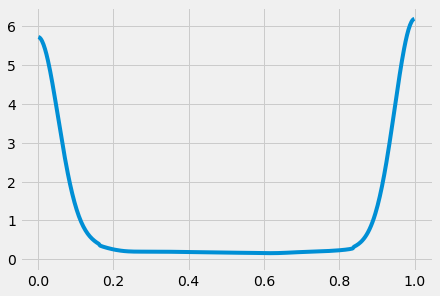

In [6]:
az.plot_kde(p);

Điều này có nghĩa là, prior cho rằng những con chimpanzee sẽ luôn luôn kéo hoặc không bao giờ kéo cần bên trái. Đây là hoàn toàn ngớ ngẩn. Ta sẽ đổi sang prior khác hợp lý hơn, với độ lệch chuẩn = 1.5.

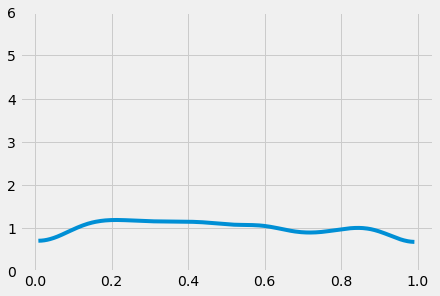

In [7]:
with handlers.seed(rng_seed=2):
    a2 = sample("a2", dist.Normal(0,1.5), sample_shape=(1000,))
    p2 = expit(a2)

az.plot_kde(p2);
plt.ylim(0,6); # Quay về cùng scale trục y

Prior mới của $\alpha$ cho rằng giá trị $p$ dao động từ 0 đến 1 và trải đều nhau. Như vậy thì hợp lý hơn.  
Ta tiếp tục với $b$.

Vì $\beta$ là biến phân nhóm *categorical*, nên ta đặt prior cho mỗi nhóm. Sau đó tính prior $p$ của mô hình.
Cuối cùng so sánh $p$ của nhóm treatment 0 và 1 bằng phép trừ và giá trị tuyệt đối.

Ta plot kết quả của 2 prior khác nhau.

In [8]:
with handlers.seed(rng_seed=3):
    n = 1000
    num_of_treatment = 4
    a = sample("a", dist.Normal(0,1.5), sample_shape=(n,))
    # prior 1: flat
    b1 = sample("b1", dist.Normal(0, 10).expand([num_of_treatment]), sample_shape=(n,))
    p1 = vmap(lambda k: expit(a + b1[:,k]))(jnp.arange(0,2))
    p1_diff = jnp.abs(p1[1] - p1[0])
              
    # prior 2: weak informative
    b2 = sample("b2", dist.Normal(0, 0.5).expand([num_of_treatment]), sample_shape=(n,))
    p2 = vmap(lambda k: expit(a + b2[:,k]))(jnp.arange(0,2))
    p2_diff = jnp.abs(p2[1] - p2[0])

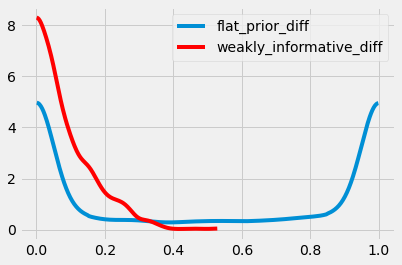

In [9]:
ax = plt.gca()
az.plot_kde(p1_diff, ax=ax, label="flat_prior_diff")
az.plot_kde(p2_diff, ax=ax, label="weakly_informative_diff", plot_kwargs={"color": "red"})
plt.legend();

Rõ ràng, với prior flat, mô hình cho rằng sự khác nhau giữa 2 treatment là hoàn toàn không có hoặc là rất khác nhau.  
Với prior chứa thông tin yếu, sự khác biệt này bị giảm đi.  
Và ta có thể tính con số trung bình của hiệu $p1 - p2$ này.

In [10]:
jnp.mean(p2_diff)

DeviceArray(0.09480755, dtype=float32)

---
## Fit mô hình và suy luận

In [11]:
## prepare data
dat_list = {"actor": d.actor.values - 1,
            "treatment": d.treatment.values,
            "pulled_left": d.pulled_left.values}

In [12]:
def model(actor, treatment, pulled_left=None, link=False):
    a = numpyro.sample("a", dist.Normal(0, 1.5).expand([7]))
    b = numpyro.sample("b", dist.Normal(0, 0.5).expand([4]))
    logit_p = a[actor] + b[treatment]
    if link:
        numpyro.deterministic("p", expit(logit_p))
    numpyro.sample("pulled_left", dist.Binomial(logits=logit_p), obs=pulled_left)


mcmc = MCMC(NUTS(model), 500, 2500, num_chains=4, chain_method="sequential")
mcmc.run(random.PRNGKey(0), **dat_list)
mcmc.print_summary(0.89)

sample: 100%|██████████| 3000/3000 [00:03<00:00, 761.17it/s, 7 steps of size 3.93e-01. acc. prob=0.92] 



                mean       std    median      5.5%     94.5%     n_eff     r_hat
      a[0]     -0.45      0.33     -0.45     -0.99      0.07   2619.63      1.00
      a[1]      3.90      0.75      3.85      2.69      5.03   7230.27      1.00
      a[2]     -0.75      0.34     -0.75     -1.28     -0.21   2645.60      1.00
      a[3]     -0.75      0.34     -0.75     -1.31     -0.24   2991.22      1.00
      a[4]     -0.45      0.34     -0.45     -1.00      0.07   2694.97      1.00
      a[5]      0.48      0.34      0.48     -0.09      0.99   2954.10      1.00
      a[6]      1.95      0.42      1.94      1.25      2.61   4387.61      1.00
      b[0]     -0.03      0.29     -0.04     -0.50      0.43   2543.53      1.00
      b[1]      0.48      0.29      0.48      0.02      0.94   2636.06      1.00
      b[2]     -0.38      0.29     -0.38     -0.84      0.07   2461.74      1.00
      b[3]      0.38      0.29      0.37     -0.10      0.81   2592.07      1.00

Number of divergences: 0


In [13]:
trace = mcmc.get_samples(group_by_chain=True)
trace['a'].shape, trace['b'].shape

((4, 2500, 7), (4, 2500, 4))

---
## Chẩn đoán MCMC có chạy tốt không
- `number of divergences` càng về `0` càng tốt.
- `r_hat` càng về `1` càng tốt
- `std` nhỏ
- Các chain tụ lại, kiểm tra bằng `plot_forest`
- `plot_trace` và `plot_rank`

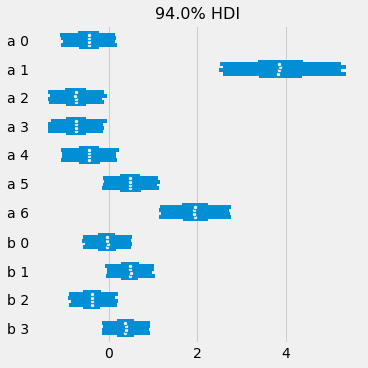

In [14]:
az.plot_forest(trace, figsize=(5,5));

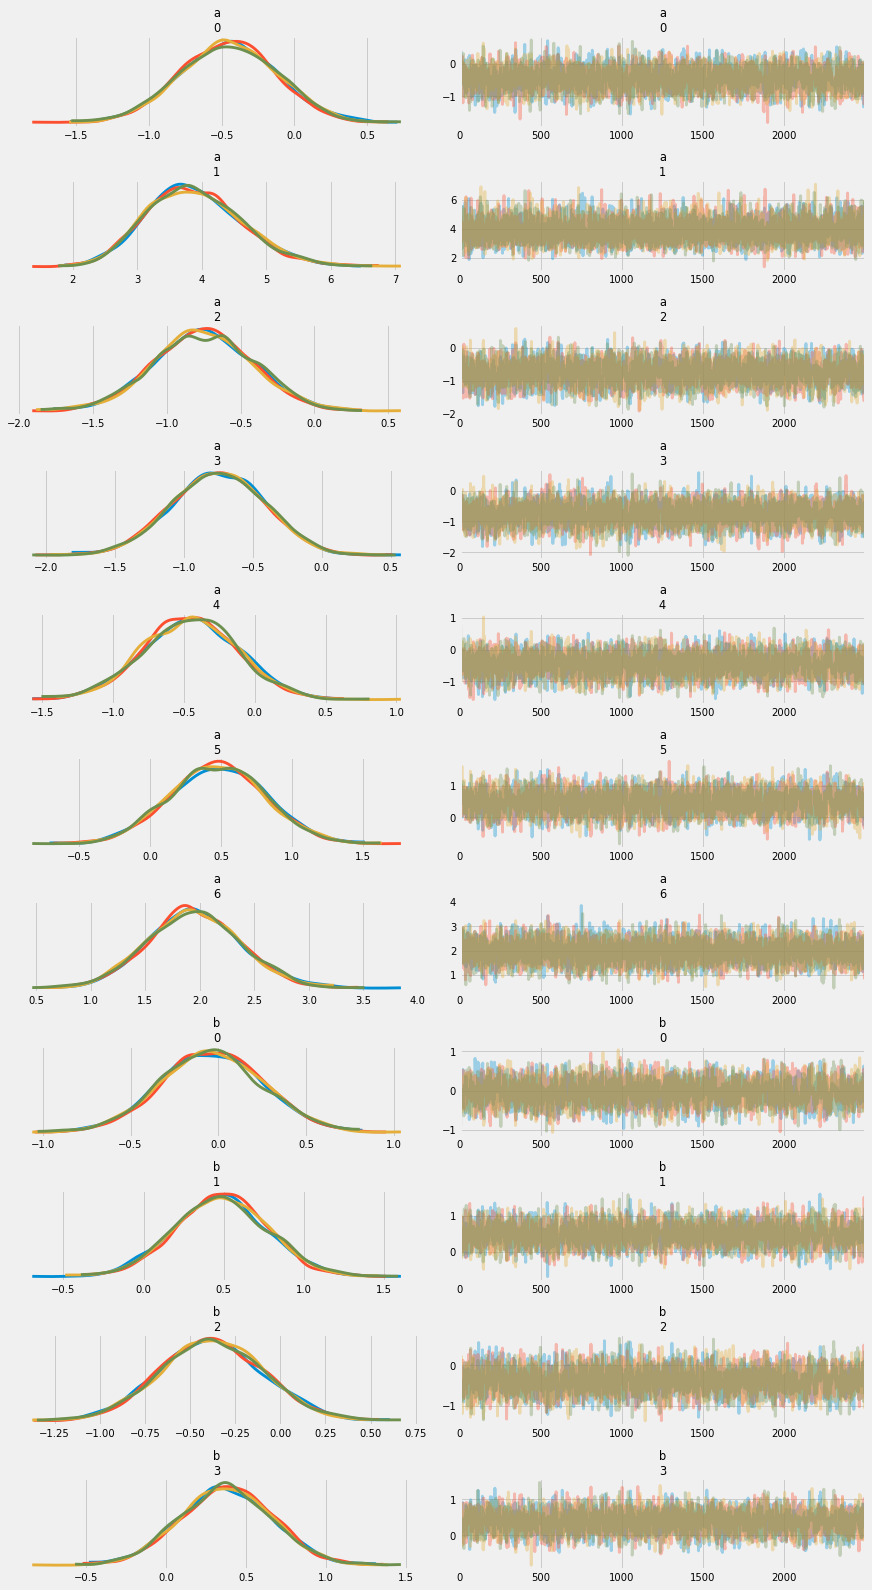

In [15]:
az.plot_trace(trace);

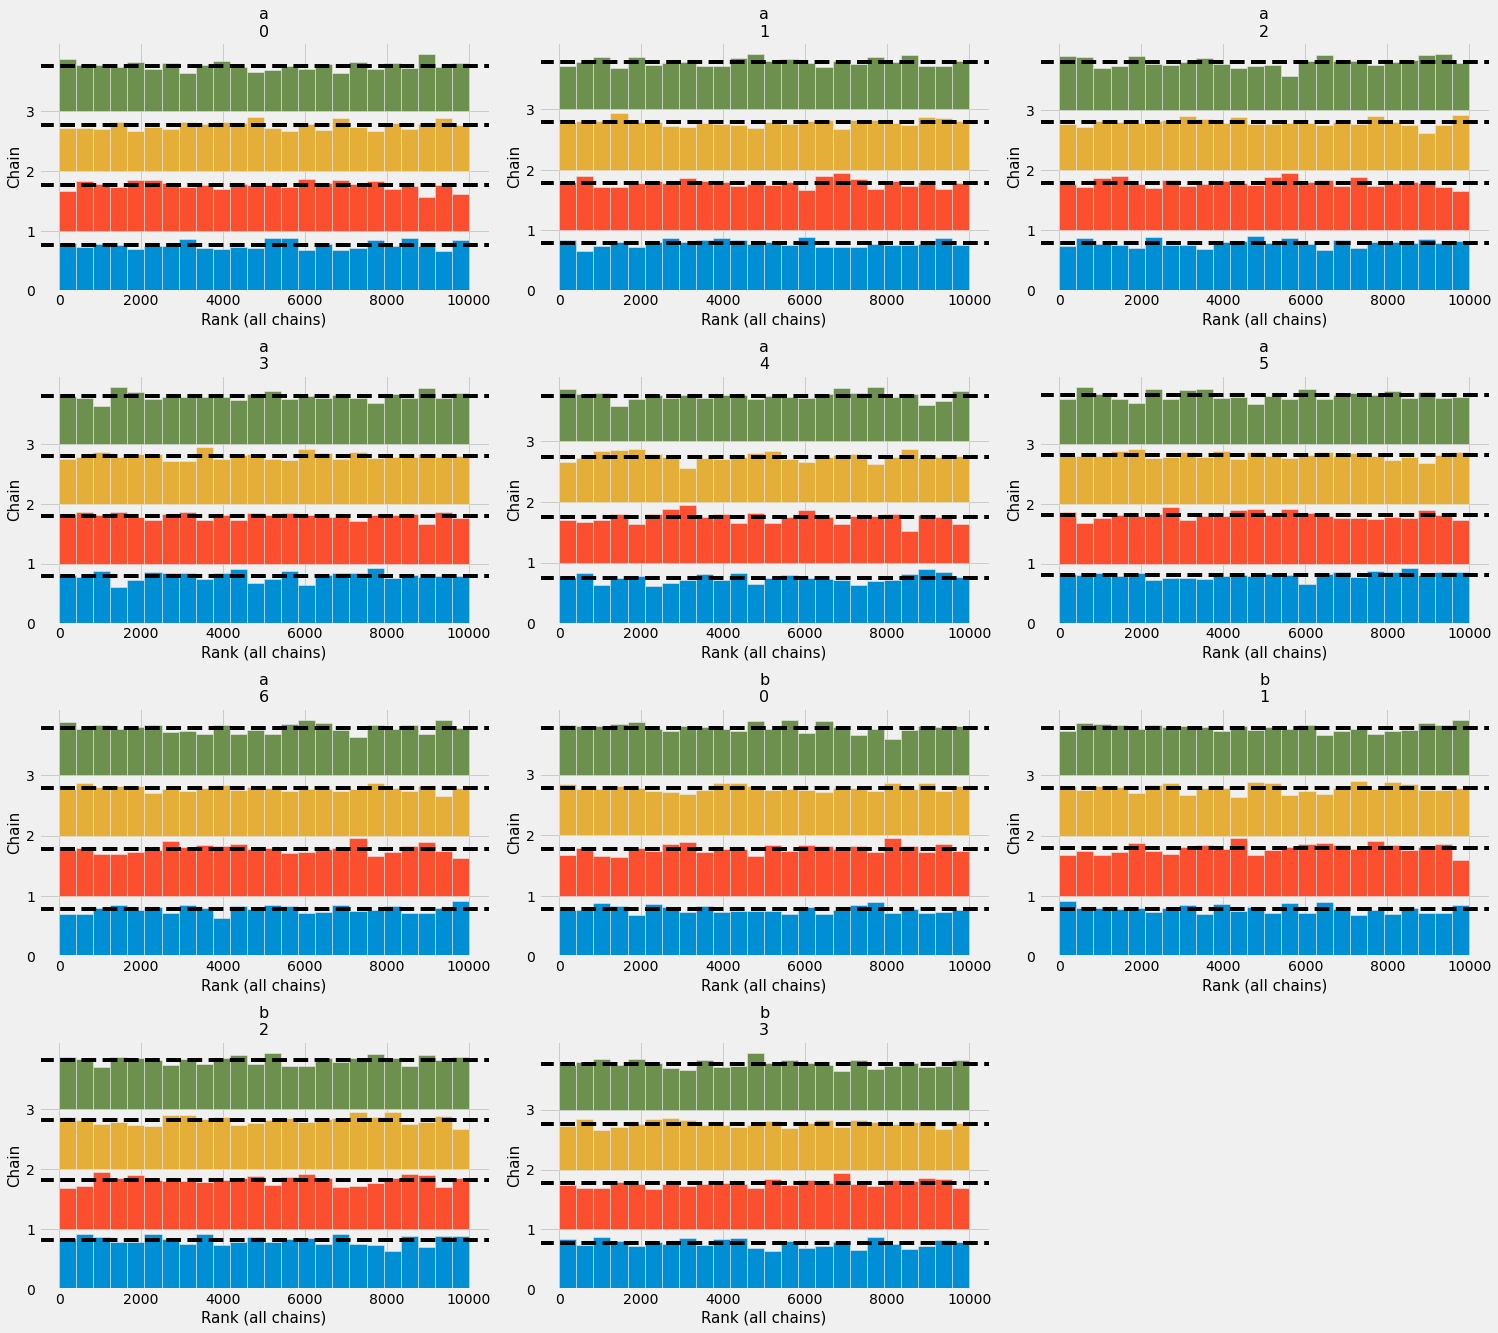

In [16]:
az.plot_rank(trace);

---
## Suy luận
Như vậy, MCMC này đạt chất lượng để thực hiện suy luận trên nó.

Một số câu hỏi được đặt ra.

### 1. Actor nào thích pull left? 
Ta dùng `plot_forest` cho param `a`. Nên nhớ phải chuyển về dạng xác suất bằng inv-logit.  
Nhận ra rằng actor 2, 7 thích pull left. Thực vậy, bộ data trong đó actor 2 luôn luôn pull left.  
Ngoài ra, sự khác nhau giữa các actor không nhiều.

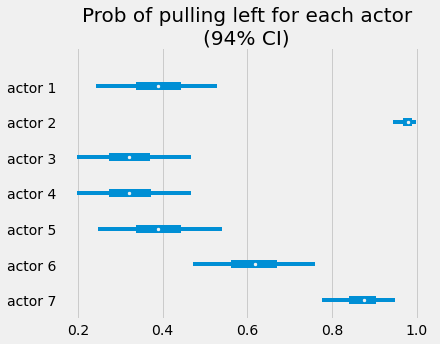

In [17]:
az.plot_forest({"a":expit(trace['a'])}, combined=True)
plt.title("Prob of pulling left for each actor\n(94% CI)", fontdict={'fontsize':20});
plt.gca().set_yticklabels((f"actor {k}" for k in range(7,0,-1))); # 0-indexed -> 1-indexed

### 2. Hiện diện của partner có ảnh hưởng đến lựa chọn prosocial không?
Tôi sẽ mô tả treatment bằng cặp vị trí lựa chọn prosocial và hiện diện của partner.  
Để rõ hơn, ta phải so sánh cặp mà prosocial bên trái và cặp prosocial bên phải.

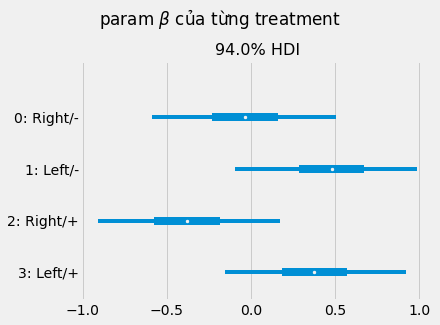

In [18]:
labs = ["0: Right/-", "1: Left/-", "2: Right/+", "3: Left/+"]
az.plot_forest(trace, combined=True, var_names="b")
plt.gca().set_yticklabels(labs[::-1]);
plt.suptitle("param $\\beta$ của từng treatment");

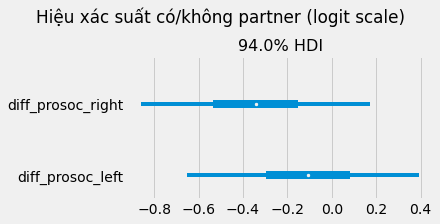

In [19]:
diff = {
    "diff_prosoc_right" : trace['b'][...,2] - trace['b'][...,0],
    "diff_prosoc_left" : trace['b'][...,3] - trace['b'][...,1]
}

az.plot_forest(diff, combined=True, figsize=(6,3));
plt.suptitle("Hiệu xác suất có/không partner (logit scale)");

Mô hình trả lời rằng: nếu prosocial bên (P), sự khác nhau giữa 2 xác suất pull left (ở logit scale) trước và sau khi có partner không thay đổi nhiều, và ngay trong khoảng HDI chứa zero.  
Tương tự như tình huống mà prosocial bên (T), cũng chứa zero, tức hiệu xác suất bằng zero, tức là không khác biệt.

Như vậy: Loài khỉ chimpanzee không có tính prosocial.

### 3. Tính Odds ratio thay vì hiệu logit
Odds ratio khi prosoc-right và có/không có partner **chính là** exp của hiệu logit.

In [20]:
jnp.exp(diff["diff_prosoc_right"].flatten()).mean()

DeviceArray(0.7360125, dtype=float32)

In [21]:
jnp.exp(diff["diff_prosoc_left"].flatten()).mean()

DeviceArray(0.933159, dtype=float32)

Cả 2 Odds ratio đều gần bằng 1. Tức là không thay đổi odds nhiều.  

Tuy nhiên, Odds ratio hạn chế ở chỗ, khi outcome càng hiếm thì odds ratio càng lớn. Nhưng nó không đảm bảo cho sự khác nhau có ý nghĩa.
Ví dụ một outcome rất hiếm 1/1e5, OR tăng 5 lần, thì outcome cũng hiếm 5/1e5 thôi.  
Thực tế, bạn nên report cả hiệu logit và OR.

---
## Kiểm tra lại bằng posterior predictive
Lấy xác suất ứng với từng cặp actor, treatment trong data, so sánh với xác suất trong kết quả posterior.  
Xác suất trong data có thể tính bằng count/sum = mean.  
Xác suất trong posterior được tính thông qua chức năng deterministic và hàm inv-logit (hay `scipy.special.expit`). Và ta cũng có thể tính được khoảng tin cậy thông qua pp bootstrap sampling.

In [22]:
raw_data = d.groupby(["actor", "treatment"]).mean().unstack()['pulled_left']
raw_data

treatment,0,1,2,3
actor,,,,
1,0.333333,0.500000,0.277778,0.555556
2,1.000000,1.000000,1.000000,1.000000
3,0.277778,0.611111,0.166667,0.333333
4,0.333333,0.500000,0.111111,0.444444
5,0.333333,0.555556,0.277778,0.500000
6,0.777778,0.611111,0.555556,0.611111
7,0.777778,0.833333,0.944444,1.000000


In [23]:
post = mcmc.get_samples()

predictor = Predictive(model, post, return_sites=["p"])
post_pred = predictor(random.PRNGKey(4),
                      actor=jnp.repeat(jnp.arange(7), 4),
                      treatment=jnp.tile(jnp.arange(4), 7),
                      link=True)
post_pred['p'].shape

(10000, 28)

In [24]:
pred_data = jnp.mean(post_pred['p'], axis=0).reshape(7,4)
pred_data

DeviceArray([[0.3826278 , 0.5073546 , 0.30658635, 0.48094413],
             [0.9740382 , 0.984233  , 0.9639289 , 0.982462  ],
             [0.3162548 , 0.43451616, 0.24798791, 0.4086909 ],
             [0.31678942, 0.4349727 , 0.24845347, 0.40922505],
             [0.38246676, 0.5071476 , 0.30639586, 0.4807298 ],
             [0.60633284, 0.7189518 , 0.5235954 , 0.69718   ],
             [0.86498684, 0.9141777 , 0.82067585, 0.9055537 ]],            dtype=float32)

In [25]:
pred_data_ci = jnp.quantile(post_pred['p'], jnp.array([0.025, 0.975]), axis=0)
pred_data_ci

DeviceArray([[0.25960386, 0.36816916, 0.19520164, 0.3424983 , 0.9285465 ,
              0.9561296 , 0.90205544, 0.95043916, 0.2007876 , 0.29911673,
              0.15108621, 0.27964264, 0.19851987, 0.297547  , 0.14989877,
              0.2744026 , 0.25668362, 0.36542296, 0.19524466, 0.34508634,
              0.46678144, 0.5907941 , 0.3816713 , 0.5681614 , 0.7649716 ,
              0.8419078 , 0.6958432 , 0.82837635],
             [0.51645887, 0.6450378 , 0.43382022, 0.62154496, 0.9958165 ,
              0.99749637, 0.9943073 , 0.9972399 , 0.4485161 , 0.57767785,
              0.367398  , 0.548542  , 0.44965798, 0.57868767, 0.3673211 ,
              0.5514458 , 0.5204514 , 0.64557034, 0.43575317, 0.6187813 ,
              0.736109  , 0.8272111 , 0.6651016 , 0.80996674, 0.93815833,
              0.9628417 , 0.9141368 , 0.958301  ]], dtype=float32)

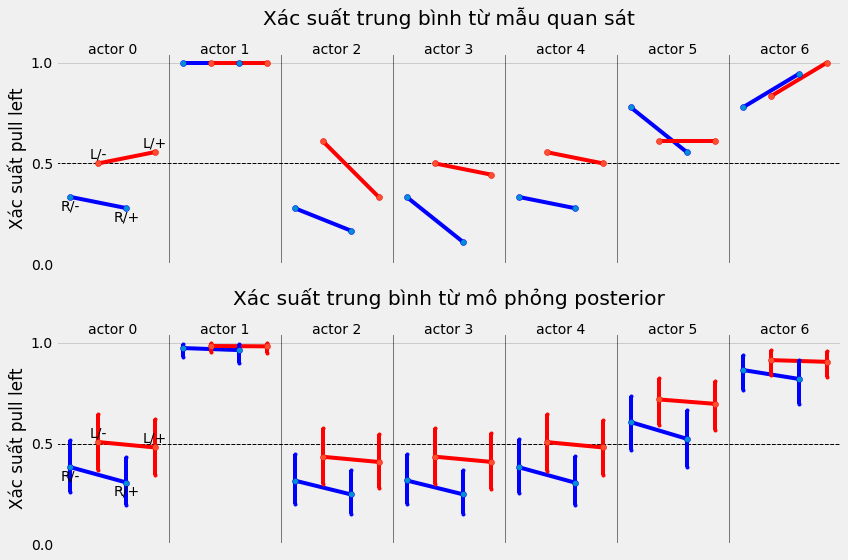

In [26]:
fig, axes = plt.subplots(2, 1, figsize=(12,8))

for ax, dat in zip(axes, [raw_data.values, pred_data]):
    # ve khung
    ax.set(
        xlim=(0.5, 28.5),
        ylim=(0, 1.05),
        xlabel="",
        ylabel="Xác suất pull left",
        xticks=[],
        yticks=[0, 0.5, 1]
    )
    ax.axhline(0.5, c="k", lw=1, ls="--")
    for j in range(7):
        ax.axvline(4*j + 4.5, c="k", lw=0.5)
    for j in range(7):
        ax.annotate(
            "actor {}".format(j),
            (4*j + 2.5, 1.1),
            ha="center",
            va="top",
            annotation_clip=False,
        )

    # ve  line
    for j in range(7):
        ax.plot(4*j + jnp.array([1, 3]), dat[j, [0, 2]], "b")
        ax.plot(4*j + jnp.array([2, 4]), dat[j, [1, 3]], "r")

    # ve points
    x = jnp.arange(1, 29).reshape(7, 4)
    ax.scatter(
        x[:, [0, 2]].flatten(),
        dat[:, [0, 2]].flatten(),
        edgecolor="b",
        zorder=3,
    )
    ax.scatter(
        x[:, [1, 3]].flatten(),
        dat[:, [1, 3]].flatten(),
        edgecolor="r",
        zorder=3
    )
    yoff = 0.01
    ax.annotate("R/-", (1, dat[0, 0] - yoff), ha="center", va="top")
    ax.annotate("L/-", (2, dat[0, 1] + yoff), ha="center", va="bottom")
    ax.annotate("R/+", (3, dat[0, 2] - yoff), ha="center", va="top")
    ax.annotate("L/+", (4, dat[0, 3] + yoff), ha="center", va="bottom")

# ve khoang tin cay post_pred
for i, j in zip(range(1, 29,2), range(2, 29,2)):
    axes[1].plot([i,i], pred_data_ci[:, i-1], ".-b")
    axes[1].plot([j,j], pred_data_ci[:, j-1], ".-r")
    
axes[0].set_title("Xác suất trung bình từ mẫu quan sát\n");
axes[1].set_title("Xác suất trung bình từ mô phỏng posterior\n");
plt.tight_layout();

Theo plot, mô hình cho rằng không có thay đổi xác suất khi có thêm partner.

---

Cám ơn các bạn đã quan tâm. Phần sau sẽ giới thiệu thêm các mô hình GLM khác như gamma, exponential,..